In [2]:
import xarray as xr
import rasterio
import geopandas as gpd
import rasterstats as rstats
import numpy as np
import pandas as pd
import netCDF4 as nc

import matplotlib.pyplot as plt

In [ ]:
shp_fo = '../gis/michiganMSA/michiganMSA.shp'
shp_df = gpd.read_file(shp_fo, encoding='ISO-8859-1')
shp_df = shp_df[shp_df['LSAD']=='M1']
shp_df = shp_df.to_crs("EPSG:4326")



<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [2]:
landcover_path = "../gis/michigan_test/NLCD2016_MI_reprojected.img"
landcover_ds = rasterio.open(landcover_path)

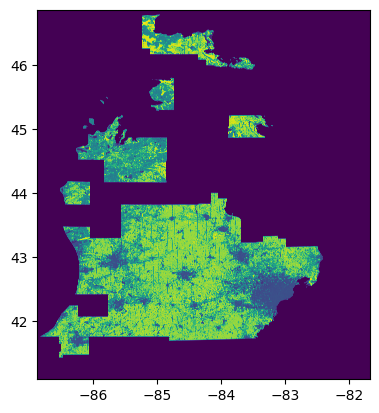

<Axes: >

In [4]:
import rasterio.plot

rasterio.plot.show(landcover_ds)


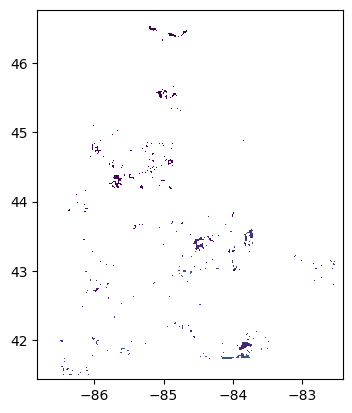

<Axes: >

In [5]:
gpp_path = "../gis/michigan_test/michigan_gpp_band1.tif"
gpp_ds = rasterio.open(gpp_path)
rasterio.plot.show(gpp_ds)

In [6]:
target_width = landcover_ds.meta['width']
target_height = landcover_ds.meta['height']
target_resolution = landcover_ds.transform[0]
print(target_width, target_height, target_resolution)

18029 20058 0.00028722672167064215


In [7]:
# save resampled gpp to .tiff
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

# Define input and output file paths
input_raster = gpp_path
output_raster = 'gpp_resampled.tif'

# Desired new resolution (e.g., 30x30 meters)
new_resolution = (target_resolution, target_resolution)

# Open the source raster
with rasterio.open(input_raster) as src:
    # Calculate the transform and dimensions for the new resolution
    transform, width, height = calculate_default_transform(
        src.crs, src.crs, src.width, src.height,
        src.bounds.left, src.bounds.bottom,
        src.bounds.right, src.bounds.top,
        dst_width=target_width,
        dst_height=target_height
    )

    # Update the metadata to the new resolution
    new_meta = src.meta.copy()
    new_meta.update({
        'transform': transform,
        'width': width,
        'height': height
    })

    print(new_meta)
    # Write the resampled raster to the output file
    with rasterio.open(output_raster, 'w', **new_meta) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=src.crs,
                resampling=Resampling.bilinear  # Use your desired resampling method
            )


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 18029, 'height': 20058, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.00024458641510899154, 0.0, -86.823668619,
       0.0, -0.0002661170841060926, 46.772656533)}


KeyboardInterrupt: 

In [7]:
# resampled gpp as variable
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import numpy as np

# Define input file path
input_raster = gpp_path

# Desired new resolution (e.g., 30x30 meters)
new_resolution = (target_resolution, target_resolution)

# Open the source raster
with rasterio.open(input_raster) as src:
    # Calculate the transform and dimensions for the new resolution
    transform, width, height = calculate_default_transform(
        src.crs, src.crs, src.width, src.height,
        src.bounds.left, src.bounds.bottom,
        src.bounds.right, src.bounds.top,
        dst_width=target_width,
        dst_height=target_height
    )

    # Create an empty array to hold the resampled data
    resampled_gpp = np.empty((height, width), dtype=src.meta['dtype'])

    # Resample each band and store it in the array
    reproject(
        source=rasterio.band(src, 1),
        destination=resampled_gpp,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=src.crs,
        resampling=Resampling.bilinear  # Use your desired resampling method
    )

print(resampled_gpp.shape)


(20058, 18029)


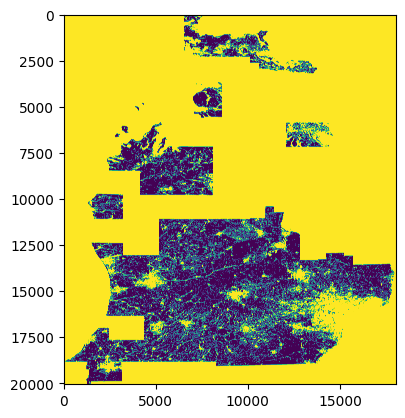

In [8]:
plt.imshow(resampled_gpp)

In [11]:
print(landcover_ds.shape)
print(resampled_gpp.shape)

(20058, 18029)
(20058, 18029)


In [9]:
landcover_data = landcover_ds.read(1)
landcover_data.shape

(20058, 18029)

In [10]:
ua_path = "../gis/michigan_test/ua_300_mi.tif"
ua_ds = rasterio.open(ua_path)
ua_data = ua_ds.read(1)

In [11]:
valid_gpp_mask = (resampled_gpp != 65535)
urban_mask = (ua_data == 1)
suburban_mask = (ua_data == 0)
forest_mask = (landcover_data == 41) | (landcover_data == 42) | (landcover_data == 43)
shrub_mask = (landcover_data == 51) | (landcover_data == 52)

mask_dict = {
    'urban_forest': urban_mask & forest_mask,
    'suburban_forest': suburban_mask & forest_mask,
    'urban_shrub': urban_mask & shrub_mask,
    'suburban_shrub': suburban_mask & shrub_mask
}

# urban_forest_val = np.nanmean(resampled_gpp[mask_dict['urban_forest_mask']])

In [12]:
urban_forest_filtered_gpp = np.where(valid_gpp_mask & mask_dict['urban_forest'], resampled_gpp, np.nan)
suburban_forest_filtered_gpp = np.where(valid_gpp_mask & mask_dict['suburban_forest'], resampled_gpp, np.nan)
urban_shrub_filtered_gpp = np.where(valid_gpp_mask & mask_dict['urban_shrub'], resampled_gpp, np.nan)
suburban_shrub_filtered_gpp = np.where(valid_gpp_mask & mask_dict['suburban_shrub'], resampled_gpp, np.nan)

In [13]:
filtered_gpp_dict = {
    'urban_forest': urban_forest_filtered_gpp,
    'suburban_forest': suburban_forest_filtered_gpp,
    'urban_shrub': urban_shrub_filtered_gpp,
    'suburban_shrub': suburban_shrub_filtered_gpp
}

In [14]:
transform = landcover_ds.transform

In [15]:
# MSA reprojected to NLCD CRS
shp_fo = '../gis/michigan_test/michiganMSAacea/michiganMSA_ACEA.shp'
shp_df = gpd.read_file(shp_fo, encoding='ISO-8859-1')
shp_df = shp_df[shp_df['LSAD']=='M1']




In [16]:
# from rasterio.mask import mask
import rasterstats
from collections import defaultdict

gpp_mean_vals = defaultdict(dict)

for _, feature in shp_df.iterrows():
    print(feature['NAME'])
    geometry = [feature['geometry']]

    # gpp_msa = rasterio.mask.mask(resampled_gpp, geometry, crop=True, filled=True, nodata=65535)
    for category, mask in mask_dict.items():
        # print(category)
        category_filtered_gpp = filtered_gpp_dict[category]
        mean_val = rasterstats.zonal_stats(geometry, category_filtered_gpp, affine=transform, stats="mean", nodata=np.nan)[0]['mean']
        # record[category] = mean_val
        gpp_mean_vals[feature['NAME']][category] = mean_val

    # res.append(record)
# print(res)
    # urban_forest_gpp_val = np.nanmean(resampled_gpp[mask_dict['urban_forest_mask']])
    # print(urban_forest_gpp_val)

Traverse City, MI


MemoryError: Unable to allocate 1.06 EiB for an array with shape (387985824, 392849362) and data type float64

In [67]:
shp_fo = '../gis/michiganMSA/michiganMSA.shp'
shp_df = gpd.read_file(shp_fo, encoding='ISO-8859-1')
shp_df = shp_df[shp_df['LSAD']=='M1']

shp_df_reprojected = shp_df.to_crs(crs=landcover_ds.crs)

In [78]:
landcover_ds.crs


ERROR 1: PROJ: internal_proj_identify: /Users/qifanwu/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [3]:
from rasterio.features import geometry_mask

gpp_filled = np.copy(resampled_gpp)

category_gpp_mean_list = []

for _, feature in shp_df_reprojected[:2].iterrows():
    print(feature['NAME'])
    record = {'name': feature['NAME']}

    for category, mask in mask_dict.items():
        geometry = [feature['geometry']]

        # calculate mean gpp value for category
        category_gpp_mean = rasterstats.zonal_stats(geometry, filtered_gpp_dict[category], affine=transform, stats="mean", nodata=np.nan)[0]['mean']
        record[category] = category_gpp_mean
        # gpp_mean_vals[feature['NAME']][category] = mean_val
        # retrieve mean gpp value for category
        # category_gpp_mean = gpp_mean_vals[feature['NAME']][category]

        geometry_mask_array = geometry_mask(
            geometries=geometry,
            transform=transform, # resampled_gpp transform, same as landcover_ds
            invert=True,
            out_shape=gpp_filled.shape
        )

        gpp_filled[~valid_gpp_mask & mask & geometry_mask_array] = category_gpp_mean

    category_gpp_mean_list.append(record)

gpp_filled

# valid_gpp_mask = (resampled_gpp != 65535)
# urban_mask = (ua_data == 1)
# suburban_mask = (ua_data == 0)

# shrub_mask = (landcover_data == 51) | (landcover_data == 52)

# mask_dict = {
#     'urban_forest': valid_gpp_mask & urban_mask & forest_mask,
#     'suburban_forest': valid_gpp_mask & suburban_mask & forest_mask,
#     'urban_shrub': valid_gpp_mask & urban_mask & shrub_mask,
#     'suburban_shrub': valid_gpp_mask & suburban_mask & shrub_mask
# }

# urban_forest_val = np.nanmean(resampled_gpp[mask_dict['urban_forest_mask']])

NameError: name 'resampled_gpp' is not defined

In [37]:
category_gpp_mean_list

[{'name': 'Traverse City, MI',
  'urban_forest': 0.02834691022792726,
  'suburban_forest': 0.06703321629515097,
  'urban_shrub': 0.047377326565143825,
  'suburban_shrub': 0.03886994015058884},
 {'name': 'Jackson, MI',
  'urban_forest': 4.070975628390252,
  'suburban_forest': 4.800075571017212,
  'urban_shrub': 4.462121212121212,
  'suburban_shrub': 3.94},
 {'name': 'Detroit-Warren-Dearborn, MI',
  'urban_forest': 4.033451447063884,
  'suburban_forest': 4.4784131262493805,
  'urban_shrub': 3.3593247588424435,
  'suburban_shrub': 4.286875725900116},
 {'name': 'Monroe, MI',
  'urban_forest': 6.406238582389477,
  'suburban_forest': 7.727171538686294,
  'urban_shrub': 6.8283582089552235,
  'suburban_shrub': 7.6656346749226},
 {'name': 'Ann Arbor, MI',
  'urban_forest': 8.595852090032155,
  'suburban_forest': 5.833244901188714,
  'urban_shrub': 7.764976958525345,
  'suburban_shrub': 3.4786269430051813},
 {'name': 'Flint, MI',
  'urban_forest': 6.0207403875625785,
  'suburban_forest': 5.45647

In [52]:
transform

Affine(0.00028722672167064215, 0.0, -86.865409349,
       0.0, -0.0002872267216571942, 46.859982244)

In [64]:
from rasterio.crs import CRS
output_tiff = "gpp_filled_mi_test.tif"

# Assuming that `resampled_gpp_transform` is the affine transform and `gpp_filled` matches your target spatial dimensions
with rasterio.open(
    output_tiff,
    "w",
    driver="GTiff",
    height=gpp_filled.shape[0],
    width=gpp_filled.shape[1],
    count=1,  # Number of bands, assuming single-band for GPP
    dtype=gpp_filled.dtype,
    crs=landcover_ds.crs,  # Replace with the correct CRS if different
    transform=transform,
) as dst:
    dst.write(gpp_filled, 1)

# gpp_filled.rasterio.write_crs('EPSG:4326', inplace=True)
# gpp_filled.rasterio.write_transform(transform, inplace=True)
# gpp_filled.rasterio.to_raster(output_tiff)

In [60]:
gpp_ds.profile

CRS.from_wkt('
             GEOGCS["WGS 84",DATUM["World Geodetic System 1984",
                                   SPHEROID["WGS 84",6378137,298.257223563]],
                                   PRIMEM["Greenwich",0],
                                   UNIT["degree",0.0174532925199433,
                                    AUTHORITY["EPSG","9122"]],
                                    AXIS["Latitude",NORTH],
                                    AXIS["Longitude",EAST]]'),
                                    'transform': Affine(0.0020810044728645626, 0.0, -86.823668619,0.0, -0.0020810044729044855, 46.772656533)

ERROR 1: PROJ: internal_proj_identify: /Users/qifanwu/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 2119, 'height': 2565, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0020810044728645626, 0.0, -86.823668619,
       0.0, -0.0020810044729044855, 46.772656533), 'blockxsize': 2119, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

ERROR 1: PROJ: internal_proj_identify: /Users/qifanwu/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 18029, 'height': 20058, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.00028722672167064215, 0.0, -86.865409349,
       0.0, -0.0002872267216571942, 46.859982244), 'blockxsize': 18029, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

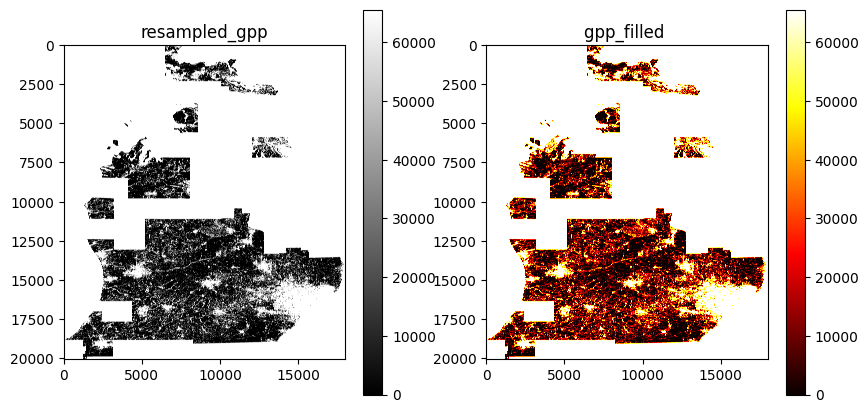

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the first array in the first subplot
axes[0].imshow(resampled_gpp, cmap='gray')
axes[0].set_title("resampled_gpp")

# Display the second array in the second subplot
axes[1].imshow(gpp_filled, cmap='hot')
axes[1].set_title("gpp_filled ")

plt.colorbar(axes[0].imshow(resampled_gpp, cmap='gray'), ax=axes[0])
plt.colorbar(axes[1].imshow(gpp_filled, cmap='hot'), ax=axes[1])

plt.show()

In [90]:
landcover_ds.crs


ERROR 1: PROJ: internal_proj_identify: /Users/qifanwu/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

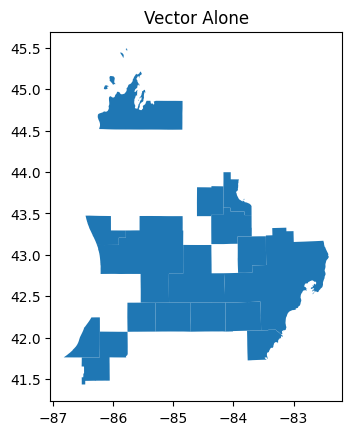

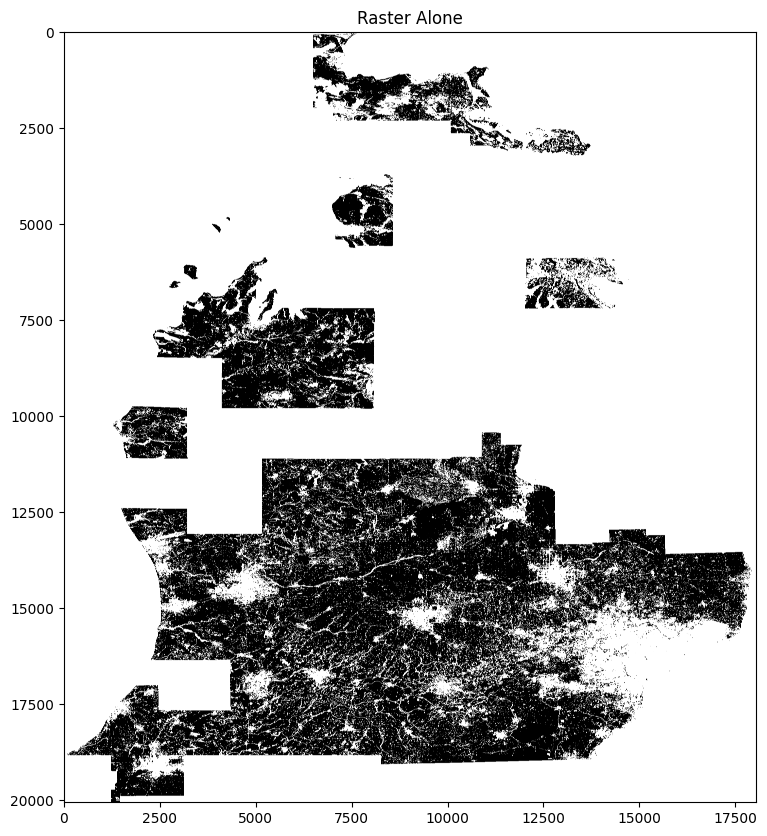

In [92]:
shp_fo = '../gis/michiganMSA/michiganMSA.shp'
shp_df = gpd.read_file(shp_fo, encoding='ISO-8859-1')
shp_df = shp_df[shp_df['LSAD']=='M1']

shp_df_reprojected = shp_df.to_crs(crs=landcover_ds.crs)

shp_df.plot()
plt.title("Vector Alone")
plt.show()

# Plot raster alone with calculated extent
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(resampled_gpp, cmap='gray', origin='upper')
plt.title("Raster Alone")
plt.show()

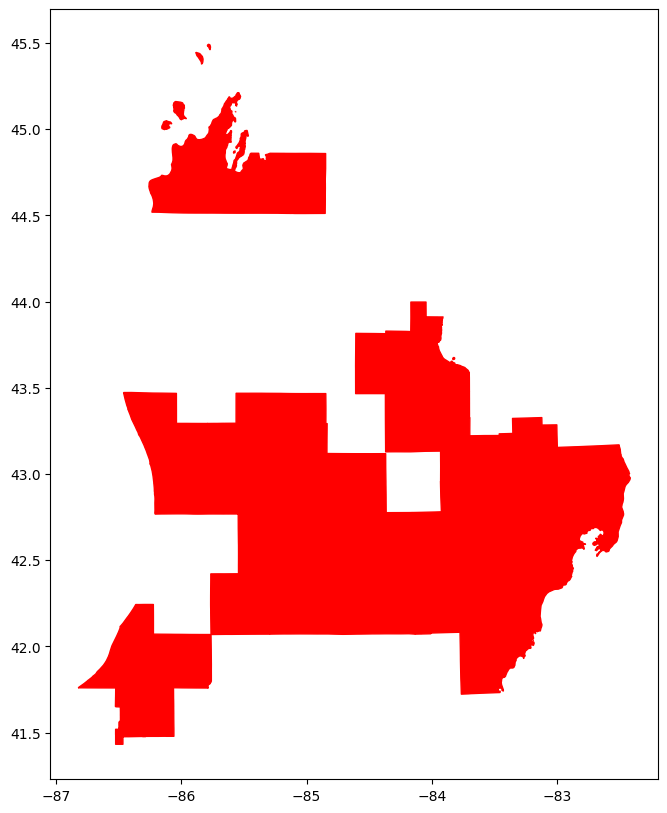

In [86]:


fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(resampled_gpp, cmap='gray',alpha=0.7, zorder=1)
shp_df_reprojected.plot(ax=ax, facecolor='red', edgecolor='red', linewidth=1, zorder=2)


plt.show()


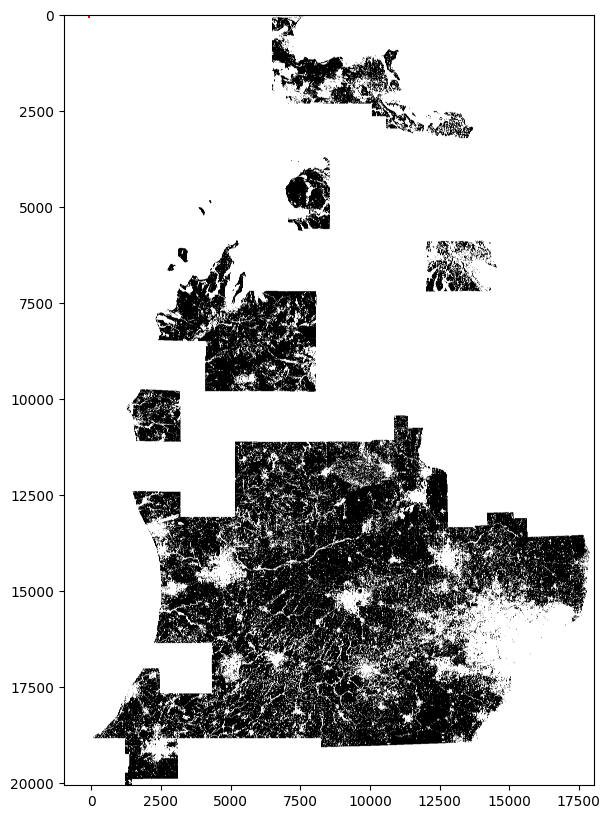

In [70]:
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(10, 10))
show(resampled_gpp, ax=ax, cmap='gray')
shp_df.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the first array in the first subplot
axes[0].imshow(resampled_gpp, cmap='gray')
axes[0].set_title("resampled_gpp")

# Display the second array in the second subplot
axes[1].imshow(gpp_filled, cmap='hot')
axes[1].set_title("gpp_filled ")

plt.colorbar(axes[0].imshow(resampled_gpp, cmap='gray'), ax=axes[0])
plt.colorbar(axes[1].imshow(gpp_filled, cmap='hot'), ax=axes[1])

plt.show()